In [1]:
import numpy as np
seed = 42
np.random.seed(seed)

In [2]:
import cv2
from glob import glob
import pandas as pd 
import numpy as np
from tqdm import tqdm

In [3]:
from sklearn.metrics import confusion_matrix
import cv2
import copy
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D,BatchNormalization,Convolution2D,MaxPooling2D
from keras.layers import Flatten,Activation
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import initializers
import numpy as np
from keras import regularizers

from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import auc,roc_curve,roc_auc_score

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from glob import glob
import pandas as pd
import os

Using TensorFlow backend.


In [4]:
pngs=glob(r'../input/train/train/*.jpg')
len(pngs)

17500

In [5]:
df=pd.read_csv(r'../input/train.csv')

In [6]:
height=32

width=32

batchsize=32

channel=1

ch=0

In [7]:
dataset=[]

y_true=[]

for i in range(len(pngs)):
    
    name=r'../input/train/train/' + str(df['id'][i])
    
    y_true.append(df['has_cactus'][i])
    
    img=cv2.imread(name,ch)
    
    dataset.append(img)

In [8]:
dataset=np.array(dataset)

y_true=np.array(y_true)

In [9]:
dataset = dataset.reshape(-1,height,width,channel)

In [10]:
y_true

array([1, 1, 1, ..., 1, 0, 1])

In [11]:
dataset.shape

(17500, 32, 32, 1)

In [12]:
img=dataset[1]
img.shape

#plt.imshow(img)
#plt.show()

(32, 32, 1)

In [13]:
type(dataset)

numpy.ndarray

In [14]:
x_train,x_val,y_train,y_val=train_test_split(dataset,y_true,shuffle=True,test_size=0.5)

print('okay')

okay


In [15]:
earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 6,
                          verbose = 1,mode='min',
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', mode='min',factor = 0.2, patience = 1, verbose = 1, min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop,reduce_lr]

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=15,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)

In [17]:
model=Sequential()
#model.add(GaussianNoise(0.1))
model.add(Convolution2D(8,kernel_size=(3,3),
                        activation='relu',
                        kernel_regularizer=regularizers.l2(0.00001),
                        input_shape=(height,width,channel)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))

model.add(Convolution2D(8,kernel_size=(3,3),
                        activation='relu',
                        kernel_regularizer=regularizers.l2(0.00001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))

model.add(Convolution2D(16,kernel_size=(5,5),
                        activation='relu',
                        kernel_regularizer=regularizers.l2(0.00001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(32*4,
                activation='relu',
                kernel_regularizer=regularizers.l2(0.00001)))

model.add(BatchNormalization())
model.add(Dropout(0.8))

model.add(Dense(1,activation='sigmoid'))

In [18]:
model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['acc'])
va = EarlyStopping(monitor='val_loss',verbose=1, patience=50)

In [19]:
output=model.fit_generator(train_datagen.flow(x=x_train, y=y_train, batch_size=batchsize),
                             epochs=40, verbose=1,
                             validation_data=test_datagen.flow(x_val,y_val,batch_size=batchsize), 
                             shuffle=False, steps_per_epoch=x_train.shape[0]//batchsize,
                             validation_steps=x_val.shape[0])

Epoch 1/40
273/273 [==============================] - 31s 113ms/step - loss: 1.2129 - acc: 0.5345 - val_loss: 1.0437 - val_acc: 0.2725
Epoch 2/40
273/273 [==============================] - 26s 94ms/step - loss: 1.0282 - acc: 0.5794 - val_loss: 0.8348 - val_acc: 0.3618
Epoch 3/40
273/273 [==============================] - 26s 94ms/step - loss: 0.9067 - acc: 0.6150 - val_loss: 0.7450 - val_acc: 0.4703
Epoch 4/40
273/273 [==============================] - 26s 94ms/step - loss: 0.8611 - acc: 0.6238 - val_loss: 0.6414 - val_acc: 0.6086
Epoch 5/40
273/273 [==============================] - 25s 93ms/step - loss: 0.7857 - acc: 0.6511 - val_loss: 0.5913 - val_acc: 0.6893
Epoch 6/40
273/273 [==============================] - 25s 93ms/step - loss: 0.7084 - acc: 0.6801 - val_loss: 0.5275 - val_acc: 0.7586
Epoch 7/40
273/273 [==============================] - 25s 92ms/step - loss: 0.6576 - acc: 0.7053 - val_loss: 0.4900 - val_acc: 0.7919
Epoch 8/40
273/273 [==============================] - 25s 92m

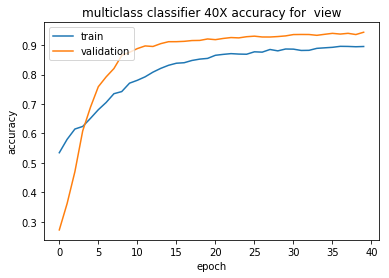

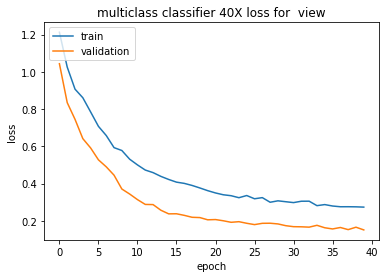

In [20]:
plt.plot(output.history['acc'])
plt.plot(output.history['val_acc'])
plt.title('multiclass classifier 40X accuracy for  view')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(output.history['loss'])
plt.plot(output.history['val_loss'])
plt.title('multiclass classifier 40X loss for  view')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
#test=pd.read_csv(r'../input/test.csv')

In [22]:
x_test=[]

y_test=[]

pngs_test=glob(r'../input/test/test/*.jpg')
#len(pngs)

for i in range(len(pngs_test)):
    
    img=cv2.imread(pngs_test[i],ch)
    
    x_test.append(img)

In [23]:
x_test=np.array(x_test)
x_test=x_test.reshape(-1,height,width,channel)

x_test=x_test/np.max(x_test)
x_test.shape

(4000, 32, 32, 1)

In [24]:
test_err=model.evaluate_generator(test_datagen.flow(x_val,y_val,batch_size=batchsize),steps=20)

print('Loss: ',test_err[0])
print('Accuracy: ',test_err[1])

Loss:  0.1397464983165264
Accuracy:  0.9515625


In [25]:
req=x_val/np.max(x_val)
predicted=model.predict_classes(req)

In [26]:
predicted

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]], dtype=int32)

In [27]:
cm_binary=confusion_matrix(y_val,predicted)

In [28]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [29]:
fpr, tpr, _ = roc_curve(y_val,predicted)
auc = roc_auc_score(y_val,predicted)

In [30]:
cm_binary

array([[1943,  245],
       [ 250, 6312]])

In [31]:
accuracy(cm_binary)

0.9434285714285714

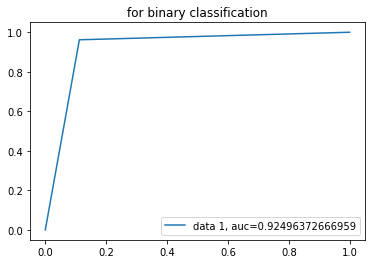

In [32]:
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.title('for binary classification')
plt.legend(loc=4)
plt.show()

In [33]:
pred=model.predict_classes(x_test)
ids=[]
test_path='../input/test/test'
label=[]
a=0
for i in tqdm(os.listdir(test_path)):
    id=i
    ids.append(id)
    label.append(pred[a])
    a=a+1

label=np.array(label,dtype='float64')
out=pd.DataFrame({'id': ids,'has_cactus':label[:,0]})

out.to_csv('cactus_identifier_net.csv',index=False,header=True)

100%|██████████| 4000/4000 [00:00<00:00, 1070658.33it/s]
